# ☘️ PLANT DISEASE CLASSIFICATION USING RESNET-9 ☘️

##### ⚠️⚠️⚠️DISCLAIMER: This notebook is beginner friendly, so don't worry if you don't know much about CNNs and Pytorch. Even if you have used TensorFlow in the past and are new to PyTorch, hang in there, everything is explained clearly and concisely. You will get a good overview of how to use PyTorch for image classification problems.

# Description of the dataset 📝

This dataset is created using offline augmentation from the original dataset. The original PlantVillage Dataset can be found [here](https://github.com/spMohanty/PlantVillage-Dataset).This dataset consists of about 87K rgb images of healthy and diseased crop leaves which is categorized into 38 different classes. The total dataset is divided into 80/20 ratio of training and validation set preserving the directory structure. A new directory containing 33 test images is created later for prediction purpose.

Note: This description is given in the dataset itself

# Our goal 🎯
Goal is clear and simple. We need to build a model, which can classify between healthy and diseased crop leaves and also if the crop have any disease, predict which disease is it.

##### Let's get started....

## Importing necessary libraries

Let's import required modules

In [ ]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full mmcv-full==1.5.0 -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 2.4 MB/s eta 0:08:22tcmalloc: large alloc 1147494400 bytes == 0x39ea0000 @  0x7f392272a615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |████████████████▌               | 1055.7 MB 2.0 MB/s eta 0:08:20tcmalloc: large alloc 1434370048 bytes == 0x7e4f6000 @  0x7f392272a615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |█████

In [ ]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version


1.9.0+cu111 True
2.26.0


In [ ]:
!git clone https://github.com/open-mmlab/mmcv.git
%cd /content/mmcv

MMCV_WITH_OPS=1 
!pip install -e .

Cloning into 'mmcv'...
remote: Enumerating objects: 14324, done.
remote: Total 14324 (delta 0), reused 0 (delta 0), pack-reused 14324
Receiving objects: 100% (14324/14324), 13.20 MiB | 22.72 MiB/s, done.
Resolving deltas: 100% (10401/10401), done.
[Errno 2] No such file or directory: '/content/mmcv'
/content/mmdetection
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/mmdetection
  Attempting uninstall: mmdet
    Found existing installation: mmdet 2.26.0
    Can't uninstall 'mmdet'. No files were found to uninstall.
  Running setup.py develop for mmdet


In [ ]:
!pip install torchsummary

from mmdet.apis import init_detector, inference_detector, show_result_pyplot

config_file = '/content/mmdetection/configs/cascade_rcnn/cascade_rcnn_r50_fpn_1x_coco.py'
# download the checkpoint from model zoo and put it in `checkpoints/`
checkpoint_file = 'https://download.openmmlab.com/mmdetection/v2.0/cascade_rcnn/cascade_rcnn_r50_fpn_1x_coco/cascade_rcnn_r50_fpn_1x_coco_20200316-3dc56deb.pth'
#checkpoint_file = 'checkpoint/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
device = 'cuda:0'
# init a detector
model = init_detector(config_file, checkpoint_file, device=device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/cascade_rcnn/cascade_rcnn_r50_fpn_1x_coco/cascade_rcnn_r50_fpn_1x_coco_20200316-3dc56deb.pth


Downloading: "https://download.openmmlab.com/mmdetection/v2.0/cascade_rcnn/cascade_rcnn_r50_fpn_1x_coco/cascade_rcnn_r50_fpn_1x_coco_20200316-3dc56deb.pth" to /root/.cache/torch/hub/checkpoints/cascade_rcnn_r50_fpn_1x_coco_20200316-3dc56deb.pth


  0%|          | 0.00/265M [00:00<?, ?B/s]

We would require torchsummary library to print the model's summary in keras style (nicely formatted and pretty to look) as Pytorch natively doesn't support that

In [ ]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model

%matplotlib inline


# 🧭 Exploring the data 🧭

Loading the data 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_dir = "/content/gdrive/MyDrive/시각인공지능/071.시설 작물 질병 진단/01.데이터/2.Validation/dataset/train"
valid_dir = "/content/gdrive/MyDrive/시각인공지능/071.시설 작물 질병 진단/01.데이터/2.Validation/dataset/valid"
diseases = os.listdir(valid_dir)

In [ ]:
# printing the disease names
print(diseases)

['단호박___healthy', '가지___healthy', '가지___unhealthy', '고추___unhealthy', '단호박___unhealthy', '딸기___healthy', '딸기___unhealthy', '고추___healthy', '쥬키니호박___unhealthy', '쥬키니호박___healthy', '오이___healthy', '오이___unhealthy', '상추___unhealthy', '수박___unhealthy', '애호박___healthy', '상추___healthy', '애호박___unhealthy', '수박___healthy', '토마토___healthy', '토마토___unhealthy', '참외___healthy', '포도___unhealthy', '참외___unhealthy', '포도___healthy']


In [ ]:
diseases =[ '단호박___healthy', '가지___healthy', '가지___unhealthy', '고추___unhealthy', '단호박___unhealthy', '딸기___healthy', '딸기___unhealthy', '고추___healthy', '쥬키니호박___unhealthy', '쥬키니호박___healthy', '오이___healthy', '오이___unhealthy', '상추___unhealthy', '수박___unhealthy', '애호박___healthy', '상추___healthy', '애호박___unhealthy', '수박___healthy', '토마토___healthy', '토마토___unhealthy', '참외___healthy', '포도___unhealthy', '참외___unhealthy', '포도___healthy']

In [ ]:
print("Total disease classes are: {}".format(len(diseases)))

Total disease classes are: 24


In [ ]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

The above cell extract the number of unique plants and number of unique diseases

In [ ]:
# unique plants in the dataset
print(f"Unique Plants are: \n{plants}")

Unique Plants are: 
['단호박', '가지', '고추', '딸기', '쥬키니호박', '오이', '상추', '수박', '애호박', '토마토', '참외', '포도']


In [ ]:
# number of unique plants
print("Number of plants: {}".format(len(plants)))

Number of plants: 12


In [ ]:
# number of unique diseases
print("Number of diseases: {}".format(NumberOfDiseases))

Number of diseases: 12


So we have images of leaves of 14 plants and while excluding healthy leaves, we have 26 types of images that show a particular disease in a particular plant.

In [ ]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
단호박___healthy,450
가지___healthy,450
가지___unhealthy,450
고추___unhealthy,450
단호박___unhealthy,450
딸기___healthy,450
딸기___unhealthy,450
고추___healthy,450
쥬키니호박___unhealthy,450
쥬키니호박___healthy,450


#### Visualizing the above information on a graph

Text(0.5, 1.0, 'Images per each class of plant disease')

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4355 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4523 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4370 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4359 missing from current font.
  font.set_text(s

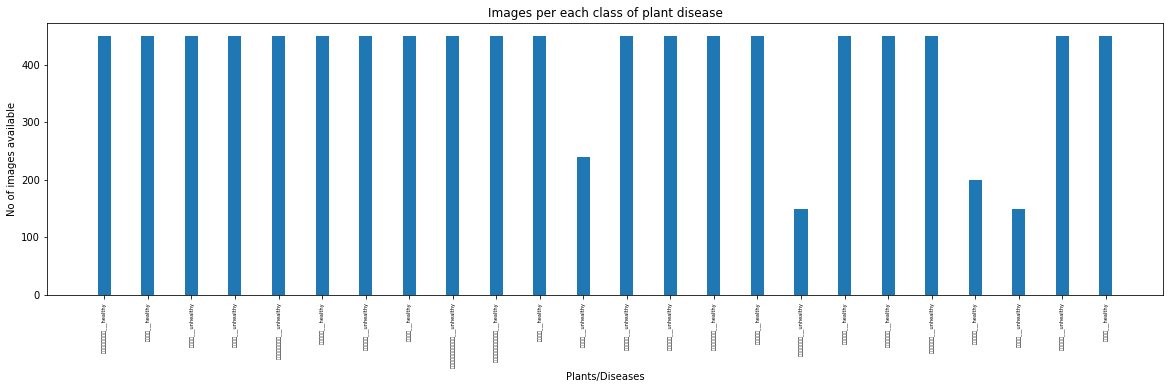

In [ ]:
# plotting number of images available for each disease
index = [n for n in range(24)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

We can see that the dataset is almost balanced for all classes, so we are good to go forward

#### Images available for training

In [ ]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 9740 images for training


# 🍳 Data Preparation for training 🍳

In [ ]:
bound_model = init_detector(config_file, checkpoint_file, device=device)
def best_box(x):
    return x[0]

load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/cascade_rcnn/cascade_rcnn_r50_fpn_1x_coco/cascade_rcnn_r50_fpn_1x_coco_20200316-3dc56deb.pth


In [ ]:
from torchvision import datasets
from PIL import Image

In [ ]:
import cv2
class GaussianNoise:
    """Applies random Gaussian noise to a tensor.

    The intensity of the noise is dependent on the mean of the pixel values.
    See https://arxiv.org/pdf/2101.04909.pdf for more information.

    """

    def __call__(self, sample: torch.Tensor) -> torch.Tensor:
        mu = sample.mean()
        snr = np.random.randint(low=4, high=8)
        sigma = mu / snr
        noise = torch.normal(torch.zeros(sample.shape), sigma)
        return sample + noise


# datasets for validation and training
transform = transforms.Compose([
        #transforms.Lambda(concat_bound),
        transforms.Resize((256, 256)),
        #transforms.ColorJitter(brightness=(0.1, 2)),
        #transforms.Lambda(lambda x: concat_bound(bound_model, x)),
        transforms.ToTensor(),
        #GaussianNoise()
        
    ])

def custom_loader(path):
  ret = Image.open(path)
  #ret = to_stacked(ret)
  return ret
train = ImageFolder(train_dir, loader = custom_loader, transform = transform)
valid = ImageFolder(valid_dir, loader = custom_loader, transform = transform) 

`torchvision.datasets` is a class which helps in loading all common and famous datasets. It also helps in loading custom datasets. I have used subclass `torchvision.datasets.ImageFolder` which helps in loading the image data when the data is arranged in this way:

----------------
root/dog/xxx.png

root/dog/xxy.png

root/dog/xxz.png

<br>

root/cat/123.png

root/cat/nsdf3.png

root/cat/asd932_.png

----------------

Next, after loading the data, we need to transform the pixel values of each image (0-255) to 0-1 as neural networks works quite good with normalized data. The entire array of pixel values is converted to torch [tensor](https://pytorch.org/tutorials/beginner/examples_tensor/two_layer_net_tensor.html#:~:text=A%20PyTorch%20Tensor%20is%20basically,used%20for%20arbitrary%20numeric%20computation.) and then divided by 255.
If you are not familiar why normalizing inputs help neural network, read [this](https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d) post.

#### Image shape 

In [ ]:
img, label = train[0]
print(img.shape, label)

# total number of classes in train set
len(train.classes)

torch.Size([3, 256, 256]) 0


24

We can see the shape (3, 256 256) of the image. 3 is the number of channels (RGB) and 256 x 256 is the width and height of the image

Label :가지___healthy(0)


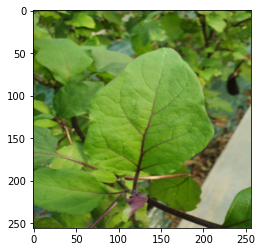

In [ ]:
# for checking some images from training dataset
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

show_image(*train[0])

In [ ]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

# setting the batch size
batch_size = 32

In [ ]:
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
valid_dl = DataLoader(valid, batch_size, num_workers=0, pin_memory=True, drop_last=True)

In [ ]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

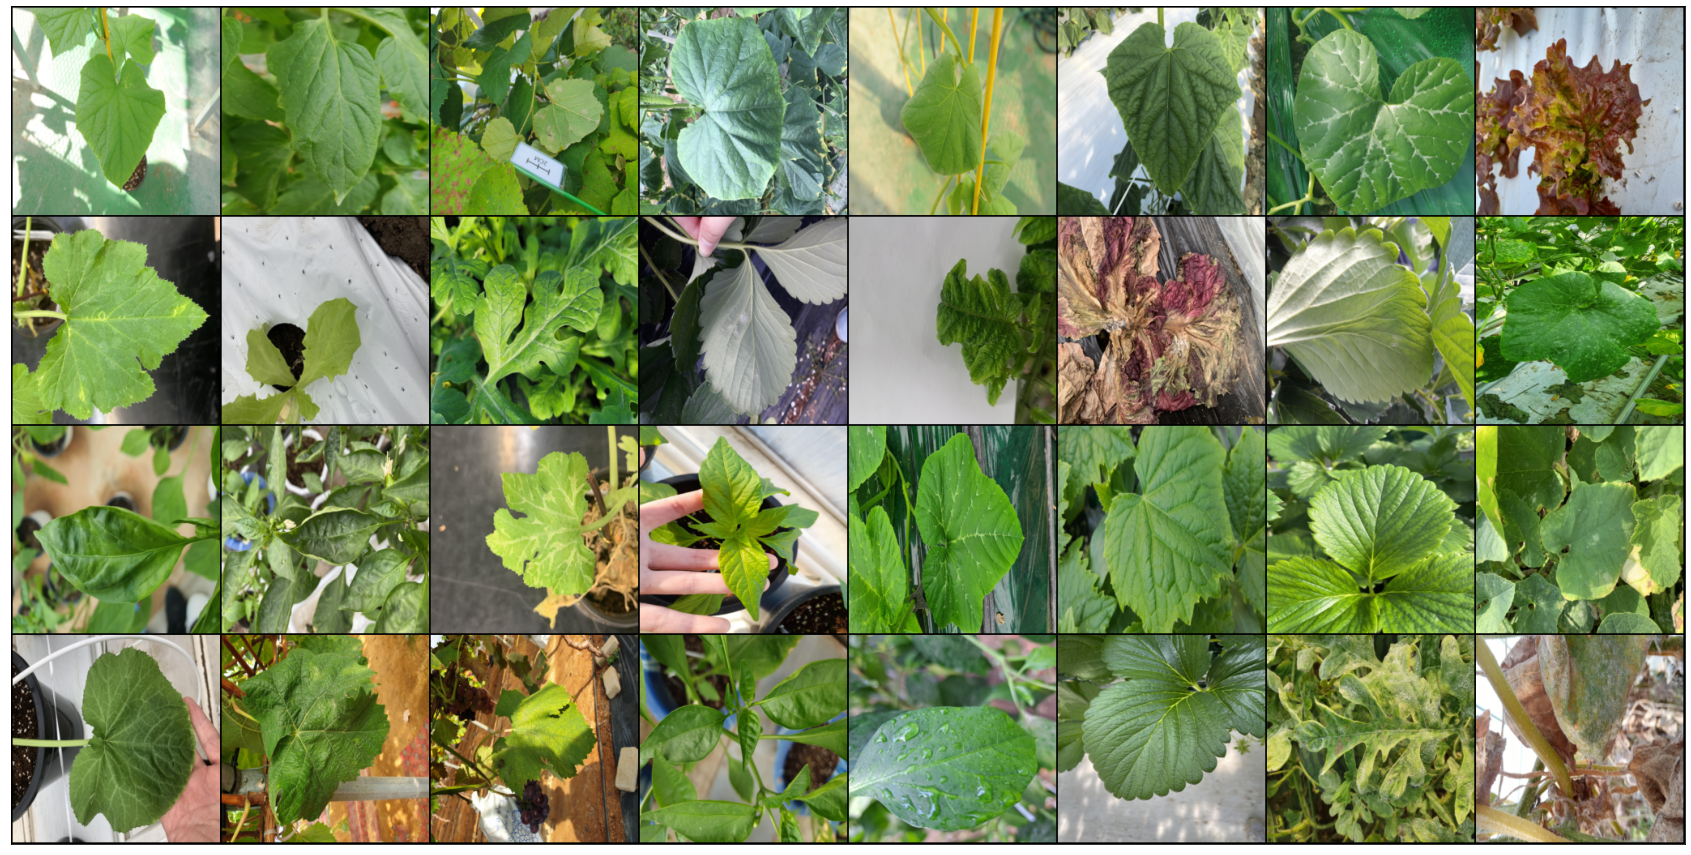

In [ ]:
# Images for first batch of training
show_batch(train_dl) 

In [ ]:
# 첫 번째 배치
test_data_list=next(iter(train_dl))[0]

In [ ]:
type(test_data_list)

torch.Tensor

In [ ]:
test_data_list

tensor([[[[0.2157, 0.1882, 0.1451,  ..., 0.5412, 0.5255, 0.5255],
          [0.1137, 0.1255, 0.1137,  ..., 0.5765, 0.5412, 0.5412],
          [0.1569, 0.1255, 0.1255,  ..., 0.5608, 0.5373, 0.5490],
          ...,
          [0.1098, 0.1176, 0.1059,  ..., 0.3529, 0.3686, 0.3569],
          [0.1216, 0.1255, 0.1176,  ..., 0.3961, 0.4392, 0.3804],
          [0.1529, 0.1373, 0.1373,  ..., 0.3333, 0.3373, 0.3529]],

         [[0.3020, 0.2314, 0.1608,  ..., 0.7216, 0.7137, 0.7098],
          [0.1412, 0.1294, 0.1255,  ..., 0.7451, 0.7216, 0.7176],
          [0.1804, 0.1294, 0.1333,  ..., 0.7255, 0.7137, 0.7216],
          ...,
          [0.2196, 0.2275, 0.2235,  ..., 0.5098, 0.5098, 0.4980],
          [0.2392, 0.2431, 0.2353,  ..., 0.5412, 0.5725, 0.5137],
          [0.2667, 0.2510, 0.2510,  ..., 0.4784, 0.4824, 0.4941]],

         [[0.1725, 0.1647, 0.1333,  ..., 0.3255, 0.3412, 0.3451],
          [0.0941, 0.1059, 0.0941,  ..., 0.3686, 0.3647, 0.3686],
          [0.1412, 0.0980, 0.0980,  ..., 0

In [ ]:
test_data=next(iter(train_dl))[0][0]

In [ ]:
tf = transforms.ToTensor()
def concat_bound(model, x):
  data = x.cpu()
  data = np.array(data)
  result_data = torch.rand(32, 6, 256, 256)
  for i, dt in enumerate(data):
    a_data = np.array(dt)*255
    a_data = a_data.astype(np.uint8)
    a_data = Image.fromarray(np.transpose(a_data,[1,2,0]))
    #a_data = a_data.resize((128,128))
    a_data = np.array(a_data)
    result = inference_detector(bound_model, a_data)
    box_list=[]
    for r in result:
        if len(r)==0:
            continue;
        box_list.append(r)
    for i, box in enumerate(box_list):
        box_list[i] = best_box(box)
      # 바운딩 박스에 해당하는 이미지 크롭
    if len(box_list)==0:
      x1 = 0; x2=255; y1 = 0; y2=255;
    elif len(box_list)>=1:
      if len(box_list)==1:
        result = box_list[0]
      else:
        result = box_list[list(np.array(box_list)[:, 4]).index(max(np.array(box_list)[:, 4]))]
      x1 = int(result[0])
      x2 = int(result[0] + result[2])
      y1 = int(result[1])
      y2 = int(result[1] + result[3])
    output = a_data[y1:y2, x1:x2]

      # 바운딩 박스에 해당하는 이미지 resize
    a = cv2.resize(a_data, dsize=(256, 256), interpolation=cv2.INTER_CUBIC) # 원본 이미지에서 여기서 바운딩 박스 리사이즈 + 원본 리사이즈를 여기서 리턴해주어야 할듯?
    b = cv2.resize(output, dsize=(256, 256), interpolation=cv2.INTER_CUBIC) # 바운딩 박스 부분 이미지
    result = np.concatenate((a,b), axis=2)
    result_data[i] =  tf(result)
  return result_data.cuda()

In [ ]:
result=concat_bound(bound_model, test_data_list)

/content/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
result.shape

torch.Size([32, 6, 256, 256])

In [ ]:
type(result)

torch.Tensor

# 🏗️ Modelling 🏗️

It is advisable to use GPU instead of CPU when dealing with images dataset because CPUs are generalized for general purpose and GPUs are optimized for training deep learning models as they can process multiple computations simultaneously. They have a large number of cores, which allows for better computation of multiple parallel processes. Additionally, computations in deep learning need to handle huge amounts of data — this makes a GPU’s memory bandwidth most suitable.
To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required

#### Some helper functions

In [ ]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## 👷 Building the model architecture 👷

In [ ]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))
        

In [ ]:
# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture 
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        self.conv1 = ConvBlock(6, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb): # xb is the loaded batch
        out = concat_bound(bound_model, xb)
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out        

In [ ]:
# defining the model and moving it to the GPU
model = to_device(ResNet9(3, len(train.classes)), device) 
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

*Getting a nicely formatted summary of our model (like in Keras). Pytorch doesn't support it natively. So, we need to install the `torchsummary` library (discussed earlier)*

In [ ]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           3,520
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

# 🏋️ Training the model 🏋️

In [ ]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
list_1=[]
def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
  
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            #print(type(batch))
            #for i, data in enumerate(batch):
              #batch[i]=concat_bound(bound_model, np.array(data))
              #print(batch[i].shape)
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        list_1.append(result)
        
    return history
    

Let's check our validation loss and accuracy

In [ ]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 12min, sys: 10.1 s, total: 12min 10s
Wall time: 22min 37s


[{'val_loss': tensor(3.1775, device='cuda:0'), 'val_accuracy': tensor(0.0460)}]

Since there are randomly initialized weights, that is why accuracy come to near 0.019 (that is 1.9% chance of getting the right answer or you can say model randomly chooses a class).
Now, declare some hyper parameters for the training of the model. We can change it if result is not satisfactory.

In [ ]:
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

Let's start training our model ....

Note: The following cell may take 15 mins to 45 mins to run depending on your GPU. In kaggle (P100 GPU) it took around 20 mins of Wall Time.

In [ ]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=1e-4, 
                             opt_func=opt_func)

### We got an accuracy of 99.2 % 🙌🙌

# 📈 Plotting 📈

#### Helper functions for plotting

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

## Validation Accuracy

In [ ]:
plot_accuracies(history)

## Validation loss

In [ ]:
plot_losses(history)

## Learning Rate overtime

In [ ]:
plot_lrs(history)

# 🧪 Testing model on test data 🧪

**We only have 33 images in test data, so let's check the model on all images**

In [ ]:
test_dir = "../input/new-plant-diseases-dataset/test"
test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [ ]:
test_images = sorted(os.listdir(test_dir + '/test')) # since images in test folder are in alphabetical order
test_images

In [ ]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]

In [ ]:
# predicting first image
img, label = test[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))

In [ ]:
# getting all predictions (actual label vs predicted)
for i, (img, label) in enumerate(test):
    print('Label:', test_images[i], ', Predicted:', predict_image(img, model))

**We can see that the model predicted all the test images perfectly!!!!**

# References
- [CIFAR10 ResNet Implementation](https://jovian.ai/aakashns/05b-cifar10-resnet)
- [PyTorch docs](https://pytorch.org/)


#### Hope you all learned something from this kernel. Do upvote if you find this useful.

#### Happy Learning....

#### Catch you guys on the next one

#### Peace ✌️